#Implementation of Ankh library from Google.

In [1]:
#@title Install and import dependencies. { display-mode: "form" }
%%capture
!pip3 install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116
!python -m pip install ankh

from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModel, AutoTokenizer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import torch, os, pandas as pd, random, matplotlib.pyplot as plt, numpy as np
import seaborn as sns
import time, random, re, shutil
import ankh

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from plm_manipulation import start_ankh, process_seqs, batch_embed, redux_fit
from ML_manipulation import one_hot_labels, simple_nn

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


In [32]:
#@title Load large Ankh model
model, tokenizer = start_ankh(device=device)

In [3]:
#@title Subset human paired sequences by the same IDs as the ProtT5 embedded sequences
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)
prott5 = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_scfv_10000.csv', index_col=0)

names = prott5['seq']
df = df[df['seq_id'].isin(names)]

protein_sequences = [df['scfv'].iloc[1], df['scfv'].iloc[2]]

In [ ]:
#@title Generate and save sequence embeddings using Ankh for 10,000 ScFv sequences
tensor_df = batch_embed(df=df, prot_col='scfv', seq_id='seq_id', batch_size=100, model=model, tokenizer=tokenizer)
tensor_df.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230805_ankh_tensor_10000.csv', index=False)

In [33]:
#@title Reembedding for heavy chain only
#@markdown 50,000 heavy chains embedded using Ankh to generate features for training a neural network.
#@markdown The labels are V-gene segment to provide a direct comparison with Ablang.
#@markdown The goal is to assess whether Ankh understands enough information to predict antibody features while enabling encoding of both heavy and light chains for paratope prediction.
#@{display-mode: "form"}

df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)
df = df.iloc[0:50000]

tensor_df = batch_embed(df=df, prot_col='sequence_alignment_aa_heavy', seq_id='seq_id', batch_size=100, model=model, tokenizer=tokenizer)

tensor_df.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_ankh_tensor_50000.csv', index=False)

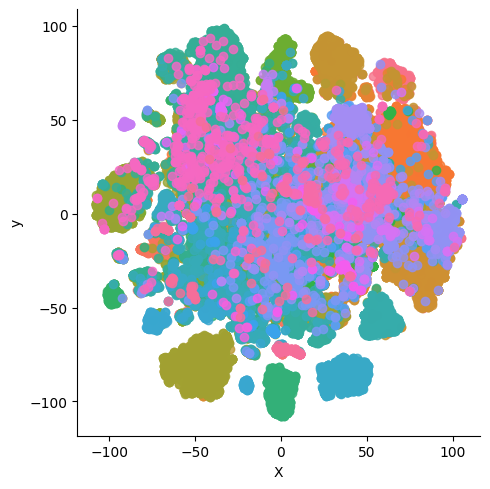

In [35]:
#@title using t-SNE and kmeans to assess latent encoding of heavy chain properties in the embedded feature space
new_df = redux_fit(model=TSNE, components=2, randstate=42, data=tensor_df.iloc[:, :-1])

new_df['cluster'] = df['v_call_heavy'].apply(lambda x: x.split('*')[0]).to_list()

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}

plt.show()

In [39]:
#@title Split embeddings into training, validation and testing sets
embeddings = tensor_df.iloc[:,:-1]
labels = df['v_call_heavy'].apply(lambda x: x.split('*')[0])
num_classes = len(np.unique(labels))
labels_encoded = one_hot_labels(labels)

X_train = embeddings.iloc[:35000, :]
y_train = labels_encoded[:35000, :]

X_val = embeddings.iloc[35000:45000, :]
y_val = labels_encoded[35000:45000, :]

X_test = embeddings.iloc[45000:50000,:]
y_test = labels_encoded[45000:50000,:]

In [43]:
#@title Build and train model
#build model
model = simple_nn(X_train.shape[1], num_classes)
#train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
1094/1094 [==============================] - 5s 4ms/step - loss: 2.1219 - accuracy: 0.3905 - val_loss: 1.1384 - val_accuracy: 0.6589
Epoch 2/20
1094/1094 [==============================] - 4s 4ms/step - loss: 1.2234 - accuracy: 0.6212 - val_loss: 0.7088 - val_accuracy: 0.7971
Epoch 3/20
1094/1094 [==============================] - 4s 4ms/step - loss: 0.9456 - accuracy: 0.7034 - val_loss: 0.5547 - val_accuracy: 0.8398
Epoch 4/20
1094/1094 [==============================] - 4s 4ms/step - loss: 0.7999 - accuracy: 0.7464 - val_loss: 0.4706 - val_accuracy: 0.8546
Epoch 5/20
1094/1094 [==============================] - 4s 4ms/step - loss: 0.7068 - accuracy: 0.7737 - val_loss: 0.4322 - val_accuracy: 0.8593
Epoch 6/20
1094/1094 [==============================] - 4s 4ms/step - loss: 0.6395 - accuracy: 0.7925 - val_loss: 0.3938 - val_accuracy: 0.8560
Epoch 7/20
1094/1094 [==============================] - 4s 4ms/step - loss: 0.5900 - accuracy: 0.8074 - val_loss: 0.3663 - val_accuracy:

In [46]:
#@title Assess model on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

313/313 [==============================] - 0s 1ms/step
Accuracy: 0.8967

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       306
           1       0.90      0.97      0.93        62
           2       1.00      0.99      0.99        83
           3       0.95      0.96      0.95       287
           4       1.00      0.00      0.00         3
           5       0.94      0.96      0.95       229
           6       0.97      0.83      0.89        35
           7       1.00      0.97      0.99       300
           8       0.98      0.97      0.97       100
           9       1.00      0.96      0.98        83
          10       0.97      1.00      0.98       219
          11       1.00      0.90      0.95        29
          12       0.88      0.93      0.91       171
          13       1.00      0.90      0.95        39
          14       0.99      0.99      0.99       334
          15       0.89      0.89     

In [45]:
#@title Assessing the model on totally unseen data
#Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#Basic Metrics
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

157/157 [==============================] - 0s 2ms/step
Accuracy: 0.8978

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       160
           1       0.88      0.92      0.90        38
           2       1.00      1.00      1.00        34
           3       0.94      0.94      0.94       143
           4       1.00      0.00      0.00         1
           5       0.92      0.96      0.94       101
           6       1.00      0.89      0.94        19
           7       0.99      0.98      0.99       124
           8       0.96      1.00      0.98        54
           9       0.97      1.00      0.99        35
          10       0.98      1.00      0.99       121
          11       1.00      0.81      0.90        16
          12       0.90      0.95      0.92        99
          13       1.00      0.79      0.88        19
          14       0.99      0.99      0.99       150
          15       0.93      1.00     

In [47]:
model.save('/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/ankh_V_gene_model.h5')